In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sqlite3
import datetime as dt
from datetime import datetime
from sqlalchemy import create_engine

In [2]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance, LabelPowerset

In [3]:
start = datetime.now()
con = sqlite3.connect('train.db')
chunk_size = 180000
j = 0
index_start = 1
for df in pd.read_csv('../../StackOverFlow/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunk_size, iterator=True, encoding='utf-8'):
    df.index += index_start
    j += 1
    print(f'{j*chunk_size} rows')
    df.to_sql('data', con, if_exists = 'append')
    index_start = df.index[-1] + 1
print("Time taken to run this cell :", datetime.now() - start)

C:\Users\Amars\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:05:46.477710


In [4]:
start = datetime.now()
con = sqlite3.connect('train.db')
num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
print("Number of rows in the database :","\n", num_rows['count(*)'].values[0])
con.close()
print('Time:', datetime.now()-start)

Number of rows in the database : 
 6034196
Time: 0:00:02.507808


In [5]:
con = sqlite3.connect("train.db")
num = pd.read_sql_query("""SELECT Tags FROM data""", con)
con.close()

In [6]:
start = datetime.now()
con = sqlite3.connect('train.db')
df_crude = pd.read_sql_query("""SELECT Title, Body, Tags, COUNT(*) as Count FROM data GROUP BY Title, Body, Tags""", con)
con.close()
print("Time: ", datetime.now() - start)

Time:  0:07:48.008022


In [7]:
start = datetime.now()
df_crude = df_crude[df_crude.Tags.notnull()]
df_crude['Tag_count'] = df_crude['Tags'].apply(lambda text: len(text.split(" ")))
print("Time: ", datetime.now() - start)
df_crude.Tag_count.value_counts()

Time:  0:00:11.811162


3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: Tag_count, dtype: int64

In [11]:
con = sqlite3.connect('Train_a.db')
pd.DataFrame(df_crude, columns = ['Title', 'Body', 'Tags']).to_sql('train_a', con)
con.close()

In [10]:
con = sqlite3.connect('Train_a.db')
tag_data = pd.read_sql_query('SELECT Tags FROM train_a',con)
con.close()

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(tag_data.Tags)

In [13]:
print('Total number of Unique Tags:',len(vectorizer.get_feature_names()))

Total number of Unique Tags: 42048


In [14]:
freq_tag = tag_dtm.sum(axis=0).A1

In [15]:
tag_data = pd.DataFrame({'Tags': vectorizer.get_feature_names(), 'Counts': freq_tag})
tag_data.to_csv('tag.csv')

In [16]:
tag_sorted_count = tag_data.sort_values(['Counts'], ascending = False).Counts.values

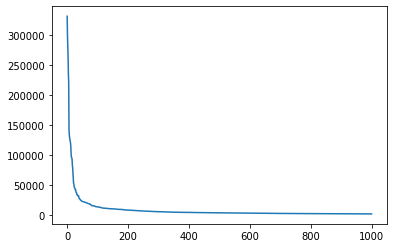

In [17]:
plt.plot(tag_sorted_count[0:1000])
plt.show()

In [18]:
i = 1000
print(f'{len(tag_data[tag_data.Counts >= i].Tags)} number of tags are used more than {i}')

1560 number of tags are used more than 1000


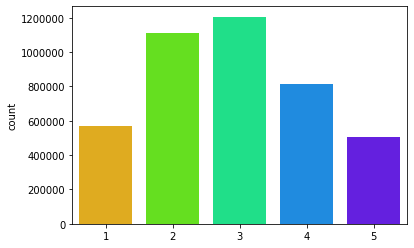

In [20]:
sns.countplot(tag_dtm.sum(axis = 1).A1, palette = 'gist_rainbow')
plt.show()

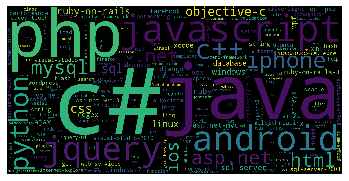

In [21]:
t = dict(zip(vectorizer.get_feature_names(),freq_tag))
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(t)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

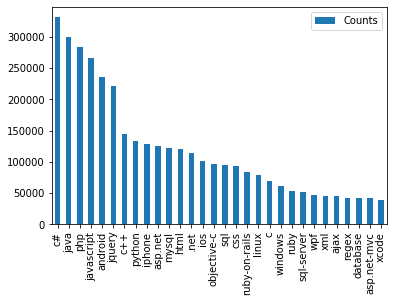

In [22]:
tag_data.sort_values(['Counts'], ascending = False).head(30).plot(kind = 'bar')
plt.xticks(np.arange(30), tag_data.sort_values(['Counts'], ascending = False).Tags)
plt.show()

### Data Preprocessing

In [29]:
def clean_html(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [31]:
sql_create_table = """CREATE TABLE IF NOT EXISTS Processedd (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
database = "Processed.db"
conn = sqlite3.connect(database)
cur = conn.cursor()
cur.execute(sql_create_table)
conn.close()

In [34]:
start = datetime.now()
read_db = 'Train_a.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = sqlite3.connect(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From train_a ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = sqlite3.connect(write_db)
    if conn_w is not None:
        checker = conn_w.cursor()
        tables_names = checker.execute("select name from sqlite_master where type='table'")
        tables = len(tables_names.fetchall())
        if tables != 0:
            checker.execute('DELETE FROM Processedd WHERE 1')

print('Time :', datetime.now() - start)

Time : 0:05:13.670902
